100%|██████████| 5000/5000 [00:10<00:00, 490.41it/s]


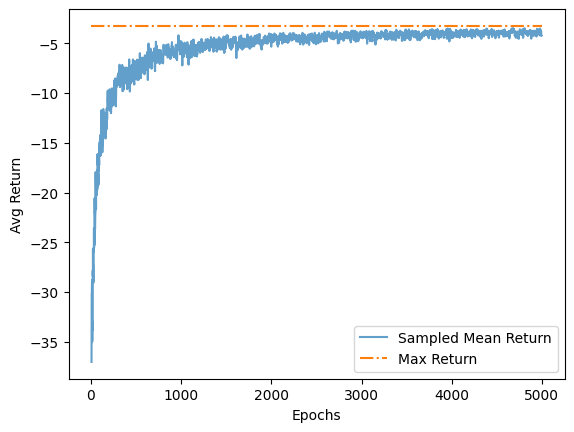

In [3]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))


class Trajectory:
    def __init__(self, states, actions, rewards, discount=1):
        self.T = len(rewards) + 1

        assert len(actions) == len(rewards), "Must have as many rewards as actions"
        assert len(states) == len(rewards) + 1, "Must be one more state than action"
        self.states = np.array(states, dtype=np.int64)
        self.actions = np.array(actions, dtype=np.int64)
        self.rewards = np.array(rewards)

        self.discount = discount

    def calculate_partial_returns(self):
        """Using the stored rewards and discount, calculate the partial returns
            G_t = \sum_{t'>=t} R_t
        Returns:
            np.array: Same shape as 'self.rewards', with G[t] = R[t]+R[t+1]+...R[T], where T=self.rewards.size
        """
        partial_returns = np.zeros(self.rewards.shape)
        G_next = 0.0
        for t in reversed(range(self.rewards.size)):
            G_next = self.rewards[t] + self.discount * G_next
            partial_returns[t] = G_next

        return partial_returns


class Problem:
    def __init__(self, seed=42, W=5, min_reward=-5, max_reward=-1):
        # Keep track of the original pseudo-random number generator state to reset to later
        original_state = np.random.get_state()
        np.random.seed(seed)

        # W is the width of the grid world problem
        self.W = W
        # Starting state is the middle tile (// performs a floor integer divide)
        self.starting_state = int(W // 2)

        # 50/50 chance of the goal being in x=0 or x=W-1
        self.goal_state = 0 if np.random.random() < 0.5 else self.W - 1

        # Randomly initialise some weights
        self.tile_rewards = np.random.rand(W) * (max_reward - min_reward) + min_reward
        # Init an array to store the "theta" values
        self.policy_parameters = np.zeros(W)

        # Reset the random number generator
        np.random.set_state(original_state)

    def run(self):
        x = self.starting_state
        states = []
        actions = []
        rewards = []
        while x != self.goal_state:
            states.append(x)
            #### TODO: Calculate probability of going right (a=+1), and replace below
            if x == 0:
                p_right = 1.0
            elif x == self.W - 1:
                p_right = 0.0
            else:
                p_right = sigmoid(self.policy_parameters[x])  # Change this to be sigmoid(a * theta[x])
            #### END

            # Select a=+1 with probability 'p_right' and a=-1 with probability '1-p_right'
            a = int((np.random.rand() < p_right) * 2 - 1)
            ####

            # Step to the next state by applying environment function
            x = x + a

            # Calculate rewards
            r = self.tile_rewards[x]

            # Update the actions and rewards
            actions.append(a)
            rewards.append(r)

        # Append the terminal state to the list
        states.append(x)
        return Trajectory(states, actions, rewards)

    def reinforce_gradient_estimate(self, N):
        grads = np.zeros_like(self.policy_parameters)
        avg_return = 0

        for _ in range(N):
            trajectory = self.run()
            avg_return += np.sum(trajectory.rewards)

            # Use the method in the trajectory to calculate the partial returns (G)
            G_t = trajectory.calculate_partial_returns()

            S_t = trajectory.states[:-1]  # Don't include the terminal state
            A_t = trajectory.actions
            theta_t = self.policy_parameters[S_t]
            grad_log_prob = A_t * (1.0 - sigmoid(A_t * theta_t))
            edge_mask = (S_t == 0) | (S_t == self.W - 1)
            grad_log_prob = np.where(edge_mask, 0.0, grad_log_prob)

            grad_contribution = G_t * grad_log_prob

            # Accumulate into parameter-specific grads (tabular: theta indexed by state)
            for x, grad in zip(S_t, grad_contribution):
                grads[x] += grad
            #### END

        # Divide by N to find means
        grads = grads / N
        avg_return = avg_return / N

        return grads, avg_return

    def train(
        self, epochs: int, N: int, learning_rate: float, use_progress: bool = True
    ):
        avg_returns = np.zeros(epochs)
        it = range(epochs) if not use_progress else tqdm(range(epochs))
        for e in it:
            grads, avg_return = self.reinforce_gradient_estimate(N)
            self.policy_parameters = self.policy_parameters + learning_rate * grads

            avg_returns[e] = avg_return
        return avg_returns

    def calculate_max_return(self):
        if self.goal_state == 0:
            return np.sum(self.tile_rewards[: self.starting_state])
        else:
            return np.sum(self.tile_rewards[self.starting_state + 1 :])


if __name__ == "__main__":
    # Seed the random number generator to get the same graph every time
    np.random.seed(1234)

    problem = Problem()

    epochs = 5000
    N = 32
    alpha = 5e-4
    returns = problem.train(epochs, N, alpha)
    max_return = problem.calculate_max_return()

    filter_width = 5
    smoothed_returns = np.convolve(
        returns, np.ones(filter_width) / filter_width, mode="same"
    )

    plt.figure()
    plt.plot(
        range(1 + filter_width, len(returns) + 1 - filter_width),
        smoothed_returns[filter_width:-filter_width],
        "-",
        label="Sampled Mean Return",
        alpha=0.7,
    )
    plt.plot([1, len(returns) + 1], [max_return, max_return], "-.", label="Max Return")
    plt.legend(loc="lower right")
    plt.xlabel("Epochs")
    plt.ylabel("Avg Return")
    plt.show()
